## First Attempt

This is slightly wrong but I still don't know why the objective function can be negative

In [49]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

In [50]:
stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 21, 'station 2': 3, 'station 3': 0, 'station 4': 48, 'station 5': 9}
optimal_levels = {'station 1': 15, 'station 2': 12, 'station 3': 18, 'station 4': 12, 'station 5': 24}
over_stations, under_stations = [], []

# fill over, under stations
for station in stations:
    if start_levels[station] >= optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] <= optimal_levels[station]:
        under_stations.append(station)
        
T = 10 # number of time steps
K = 2 # number of trucks
L = 3 # number of bikes that can be moved in one time step

In [51]:
model = gp.Model("bike_rebalancing")
# N = G.nodes()
# What is this for??

In [52]:
'''
decision variables: 
x: whether or not truck k is at station s at time t
y: number of bikes available to truck k is at station s at time t
b: number of bikes in truck k at time t
'''
x, y, b = {}, {}, {}

for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s,t,k] = model.addVar(name="x_%s,%s,%s"%(s,t,k), vtype=GRB.BINARY)
            y[s,t,k] = model.addVar(name="y_%s,%s,%s"%(s,t,k), vtype=GRB.INTEGER)
        b[t,k] = model.addVar(name="b_%s,%s"%(t,k), vtype=GRB.INTEGER)

model.update()

In [53]:
# objective function

objective = gp.quicksum((optimal_levels[s] - y[s, T, 1]) for s in under_stations) \
            + gp.quicksum((y[s,T,1] - optimal_levels[s]) for s in over_stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

In [54]:
# constraints

# each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s,t,k] for s in stations) == 1)

# initiate
for s in stations:
    model.addConstr(sum(y[s,1,k] for k in range(1, K+1)) == start_levels[s])

# rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s,t,k] for k in range(1, K+1)))
        model.addConstr(sum(y[s,t,k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s,t,k] for k in range(1, K+1)))
        model.addConstr(sum(y[s,t,k] for k in range(1, K+1)) <= optimal_levels[s])

# total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s,t,k] for s in stations) + b[t,k] == sum(y[s,1,k] for s in stations) + b[1,k])

# can move only when truck is at station, number of bikes moved is bounded by 
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s,t,k] - y[s,t-1,k] <= L * x[s,t,k])
            model.addConstr(y[s,t-1,k] - y[s,t,k] <= L * x[s,t,k])

# add last constraint later...

In [55]:
model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 325 rows, 220 columns and 1066 nonzeros
Model fingerprint: 0x8427abed
Variable types: 0 continuous, 220 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Found heuristic solution: objective 72.0000000
Presolve removed 55 rows and 38 columns
Presolve time: 0.00s
Presolved: 270 rows, 182 columns, 770 nonzeros
Variable types: 0 continuous, 182 integer (88 binary)

Root relaxation: objective -1.200000e+01, 184 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0             

## Slight Fix... without dummy

If we want, we can have random starting and optimal levels...

In [58]:
import random

B = 200 # total bikes
S = 8 # total stations

stations = ['station {}'.format(s) for s in range(1,S+1)]
start_levels = {}
optimal_levels = {}
for station in stations:
    start_levels[station] = 0
    optimal_levels[station] = 0
for _ in range(B):
    start_levels[random.choice(stations)] += 1
    optimal_levels[random.choice(stations)] += 1

Now, we run the simulation:

In [94]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 30, 'station 2': 30, 'station 3': 0, 'station 4': 0, 'station 5': 15}
optimal_levels = {'station 1': 15, 'station 2': 15, 'station 3': 15, 'station 4': 15, 'station 5': 15}
over_stations, under_stations, balanced_stations = [], [], []

# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
    else:
        balanced_stations.append(station)
        
T = 20 # Number of time steps
K = 2 # Number of trucks
L = 3 # Number of bikes that can be moved in one time step

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b = {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints

# Each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) == 1)

# Initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])
    for s in balanced_stations:
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) == start_levels[s])

# Total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s, t, k] for s in stations) + b[t, k] == sum(y[s, 1, k] for s in stations) + b[1, k])

# Can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8 in paper
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L + (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L - (y[s,t,k] - y[s,t-1,k]))
        for s in under_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L - (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L + (y[s,t,k] - y[s,t-1,k]))

# TEST: each truck can only house L bikes
for k in range(1, K+1):
    for t in range(1,T+1):
        model.addConstr(b[t,k] <= L)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 999 rows, 445 columns and 3452 nonzeros
Model fingerprint: 0x467f4653
Variable types: 0 continuous, 445 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 285 rows and 31 columns
Presolve time: 0.02s
Presolved: 714 rows, 414 columns, 2522 nonzeros
Variable types: 0 continuous, 414 integer (196 binary)
Found heuristic solution: objective 57.0000000
Found heuristic solution: objective 54.0000000

Root relaxation: objective 0.000000e+00, 392 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestB

# Now adding dummy

In [12]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

### Random positions and levels

In [13]:
import random

B = 300 # total bikes
S = 8 # total stations

stations = ['station {}'.format(s) for s in range(1,S+1)]
start_levels = {}
optimal_levels = {}
for station in stations:
    start_levels[station] = 0
    optimal_levels[station] = 0
for _ in range(B):
    start_levels[random.choice(stations)] += 1
    optimal_levels[random.choice(stations)] += 1

positions = {}
for station in stations:
    positions[station] = (random.random(), random.random())

neighbors = {}
for s in stations:
    limit = 0.3
    neighbors[s] = [s1 for s1 in stations if np.linalg.norm(np.array(positions[s] - np.array(positions[s1]))) < 0.7]

### Set positions and levels

In [ ]:
stations = ['station 1', 'station 2', 'station 3', 'station 4']
start_levels = {'station 1': 30, 'station 2': 15, 'station 3': 15, 'station 4': 0}
optimal_levels = {'station 1': 15, 'station 2': 15, 'station 3': 15, 'station 4': 15}

positions = {'station 1': (-1.0, -1.0), 'station 2': (1.0, -1.0), 'station 3': (-1.0, 1.0), 'station 4': (1.0, 1.0)}
neighbors = {'station 1': ['station 1', 'station 2', 'station 3'],
           'station 2': ['station 1', 'station 2', 'station 4'],
           'station 3':['station 1', 'station 3', 'station 4'],
           'station 4':['station 2', 'station 3', 'station 4']
           }

### Rest of model

In [19]:
over_stations, under_stations, balanced_stations = [], [], []
# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
    else:
        balanced_stations.append(station)
        
T = 20 # Number of time steps
K = 2 # Number of trucks
L = 3 # Number of bikes that can be moved in one time step

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b = {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints:

# Constraint 1: can only move to an adjacent station
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(x[s,t,k] <= x[s,t-1,k] + gp.quicksum(x[s1,t-1,k] for s1 in neighbors[s]))


# Constraint 2: each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) == 1)

# Constraint 3: initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Constraint 4 & 5: rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])
    for s in balanced_stations:
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) == start_levels[s])

# Constraint 6: total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s, t, k] for s in stations) + b[t, k] == sum(y[s, 1, k] for s in stations) + b[1, k])

# Constraint 7: can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8: can either travel or load/unload, not both
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L + (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L - (y[s,t,k] - y[s,t-1,k]))
        for s in under_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L - (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L + (y[s,t,k] - y[s,t-1,k]))

# TEST: each truck can only house L bikes
for k in range(1, K+1):
    for t in range(1,T+1):
        model.addConstr(b[t,k] <= L)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

# At beginning and end, there must be no bikes in trucks
model.addConstr(gp.quicksum(b[T, k] for k in range(1, K+1)) == 0)
model.addConstr(gp.quicksum(b[1, k] for k in range(1, K+1)) == 0)

model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 1986 rows, 688 columns and 7756 nonzeros
Model fingerprint: 0x5f4d5be8
Variable types: 0 continuous, 688 integer (320 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+01]
Presolve removed 389 rows and 5 columns
Presolve time: 0.07s
Presolved: 1597 rows, 683 columns, 6138 nonzeros
Variable types: 0 continuous, 683 integer (321 binary)
Found heuristic solution: objective 46.0000000

Root relaxation: objective 0.000000e+00, 875 iterations, 0.08 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.0000

In [26]:
x

{('station 1', 1, 1): <gurobi.Var x_station 1,1,1 (value -0.0)>,
 ('station 2', 1, 1): <gurobi.Var x_station 2,1,1 (value -0.0)>,
 ('station 3', 1, 1): <gurobi.Var x_station 3,1,1 (value -0.0)>,
 ('station 4', 1, 1): <gurobi.Var x_station 4,1,1 (value -0.0)>,
 ('station 5', 1, 1): <gurobi.Var x_station 5,1,1 (value -0.0)>,
 ('station 6', 1, 1): <gurobi.Var x_station 6,1,1 (value 1.0)>,
 ('station 7', 1, 1): <gurobi.Var x_station 7,1,1 (value -0.0)>,
 ('station 8', 1, 1): <gurobi.Var x_station 8,1,1 (value -0.0)>,
 ('station 1', 1, 2): <gurobi.Var x_station 1,1,2 (value 0.0)>,
 ('station 2', 1, 2): <gurobi.Var x_station 2,1,2 (value -0.0)>,
 ('station 3', 1, 2): <gurobi.Var x_station 3,1,2 (value 0.0)>,
 ('station 4', 1, 2): <gurobi.Var x_station 4,1,2 (value 1.0)>,
 ('station 5', 1, 2): <gurobi.Var x_station 5,1,2 (value -0.0)>,
 ('station 6', 1, 2): <gurobi.Var x_station 6,1,2 (value -0.0)>,
 ('station 7', 1, 2): <gurobi.Var x_station 7,1,2 (value -0.0)>,
 ('station 8', 1, 2): <gurobi

## Graphing in a circle

Truck 1 path: [(1, 'station 2', '0 bikes'), (2, 'station 2', '3 bikes'), (3, 'station 3', '3 bikes'), (4, 'station 3', '0 bikes'), (5, 'station 2', '0 bikes'), (6, 'station 2', '3 bikes'), (7, 'station 4', '3 bikes'), (8, 'station 4', '0 bikes'), (9, 'station 2', '0 bikes'), (10, 'station 2', '3 bikes'), (11, 'station 3', '3 bikes'), (12, 'station 3', '0 bikes'), (13, 'station 2', '0 bikes'), (14, 'station 2', '3 bikes'), (15, 'station 3', '3 bikes'), (16, 'station 3', '0 bikes'), (17, 'station 2', '0 bikes'), (18, 'station 2', '3 bikes'), (19, 'station 3', '3 bikes'), (20, 'station 3', '0 bikes')]
Truck 2 path: [(1, 'station 1', '0 bikes'), (2, 'station 1', '3 bikes'), (3, 'station 4', '3 bikes'), (4, 'station 4', '0 bikes'), (5, 'station 1', '0 bikes'), (6, 'station 1', '3 bikes'), (7, 'station 4', '3 bikes'), (8, 'station 4', '0 bikes'), (9, 'station 1', '0 bikes'), (10, 'station 1', '3 bikes'), (11, 'station 4', '3 bikes'), (12, 'station 4', '0 bikes'), (13, 'station 1', '0 bikes')

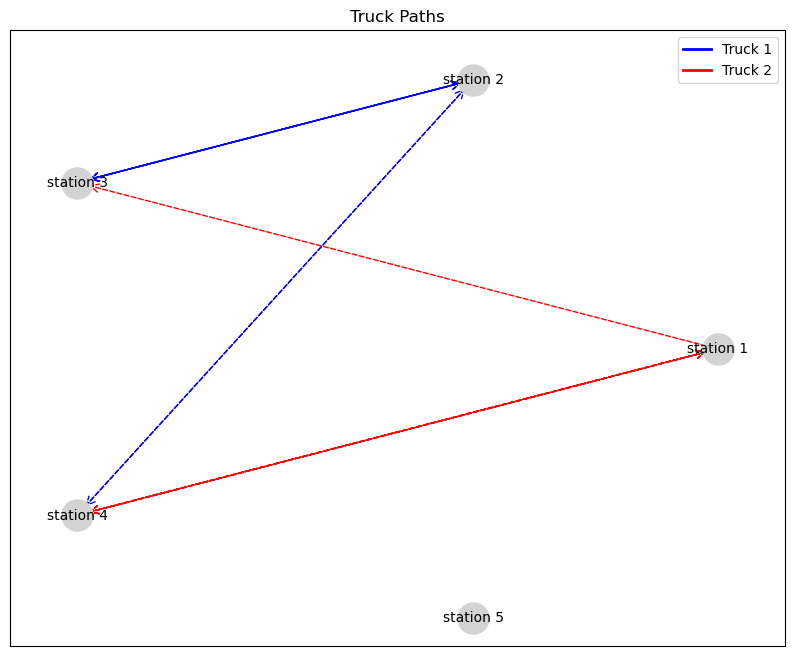

In [97]:
import matplotlib.pyplot as plt
import networkx as nx

truck_paths = {}

# if model.status == GRB.OPTIMAL:
if True:
    for k in range(1, K+1):
        path = []
        for t in range(1, T+1):
            for s in stations:
                if x[s, t, k].x > 0.5:  # If the truck k is at station s at time t
                    path.append((t, s, '{} bikes'.format(int(b[t,k].x))))
                    break
        truck_paths[k] = path
        print(f"Truck {k} path: {path}")
else:
    print("No optimal solution found.")


# Visualize the truck paths
def plot_paths(truck_paths):
    G = nx.DiGraph()
    
    num_stations = len(stations)
    angle_step = 2 * np.pi / num_stations
    radius = 0.1  # You can adjust the radius as needed

    pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

    # Add nodes
    for station in stations:
        G.add_node(station)
    
    # Add edges with arrows for each truck path
    for k, path in truck_paths.items():
        for i in range(len(path) - 1):
            t1, s1 = path[i][:2]
            t2, s2 = path[i + 1][:2]
            G.add_edge(s1, s2, truck=k, time_step=t1)
    
    edge_colors = ['blue', 'red', 'green', 'purple']  # Different colors for different trucks
    # edge_styles = ['solid', 'dashed']  # Different styles for different trucks
    
    plt.figure(figsize=(10, 8))
    for k, path in truck_paths.items():
        # edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1)]
        # The above includes time steps where the trucks don't move. Below I have removed such trips
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][1] != path[i + 1][1]]
        nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15, 
                               edge_color=edge_colors[k - 1], style='dashed', label=f'Truck {k}')
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=10)

    from matplotlib.lines import Line2D
    legend_handles = [Line2D([0], [0], color=edge_colors[k - 1], lw=2, label=f'Truck {k}') for k in range(1, K+1)]
    plt.legend(handles=legend_handles)
    
    plt.title("Truck Paths")
    plt.show()

# Plot the paths
plot_paths(truck_paths)



# Graphing Better

Truck 1 path: [(1, 'station 3', '0 bikes'), (2, 'station 3', '3 bikes'), (3, 'station 7', '3 bikes'), (4, 'station 4', '3 bikes'), (5, 'station 1', '3 bikes'), (6, 'station 1', '0 bikes'), (7, 'station 4', '0 bikes'), (8, 'station 6', '0 bikes'), (9, 'station 6', '3 bikes'), (10, 'station 8', '3 bikes'), (11, 'station 8', '0 bikes'), (12, 'station 7', '0 bikes'), (13, 'station 3', '0 bikes'), (14, 'station 3', '3 bikes'), (15, 'station 7', '3 bikes'), (16, 'station 4', '0 bikes'), (17, 'station 7', '0 bikes'), (18, 'station 7', '1 bikes'), (19, 'station 8', '1 bikes'), (20, 'station 8', '0 bikes')]
Truck 2 path: [(1, 'station 4', '0 bikes'), (2, 'station 4', '3 bikes'), (3, 'station 1', '3 bikes'), (4, 'station 1', '1 bikes'), (5, 'station 4', '1 bikes'), (6, 'station 4', '3 bikes'), (7, 'station 1', '3 bikes'), (8, 'station 1', '0 bikes'), (9, 'station 5', '0 bikes'), (10, 'station 5', '3 bikes'), (11, 'station 8', '3 bikes'), (12, 'station 8', '0 bikes'), (13, 'station 5', '0 bikes')

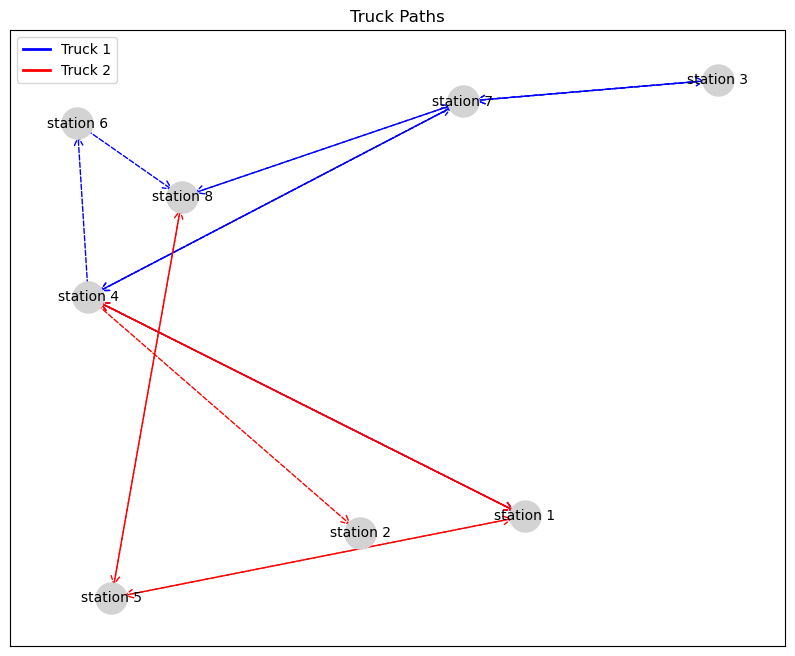

In [17]:
import matplotlib.pyplot as plt
import networkx as nx

truck_paths = {}

# if model.status == GRB.OPTIMAL:
if True:
    for k in range(1, K+1):
        path = []
        for t in range(1, T+1):
            for s in stations:
                if x[s, t, k].x > 0.5:  # If the truck k is at station s at time t
                    path.append((t, s, '{} bikes'.format(int(b[t,k].x))))
                    break
        truck_paths[k] = path
        print(f"Truck {k} path: {path}")
else:
    print("No optimal solution found.")


# Visualize the truck paths
def plot_paths(truck_paths):
    G = nx.DiGraph()
    
    # num_stations = len(stations)
    # side_length = int(np.ceil(np.sqrt(num_stations)))  # Number of nodes along one side of the square
    
    # # Determine the step size to spread nodes evenly in the square
    # step = 2 / (side_length - 1)
    
    # # Generate positions for each node
    # pos = {stations[i]: ((i % side_length) * step - 1, (i // side_length) * step - 1) for i in range(num_stations)}
    
    # Add nodes
    for station in stations:
        G.add_node(station)
    
    # Add edges with arrows for each truck path
    for k, path in truck_paths.items():
        for i in range(len(path) - 1):
            t1, s1 = path[i][:2]
            t2, s2 = path[i + 1][:2]
            G.add_edge(s1, s2, truck=k, time_step=t1)
    
    edge_colors = ['blue', 'red', 'green', 'purple']  # Different colors for different trucks
    # edge_styles = ['solid', 'dashed']  # Different styles for different trucks
    
    plt.figure(figsize=(10, 8))
    for k, path in truck_paths.items():
        # edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1)]
        # The above includes time steps where the trucks don't move. Below I have removed such trips
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][1] != path[i + 1][1]]
        nx.draw_networkx_edges(G, positions, edgelist=edges, arrowstyle='->', arrowsize=15, 
                               edge_color=edge_colors[k - 1], style='dashed', label=f'Truck {k}')
    
    nx.draw_networkx_nodes(G, positions, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, positions, font_size=10)

    from matplotlib.lines import Line2D
    legend_handles = [Line2D([0], [0], color=edge_colors[k - 1], lw=2, label=f'Truck {k}') for k in range(1, K+1)]
    plt.legend(handles=legend_handles)
    
    plt.title("Truck Paths")
    plt.show()

# Plot the paths
plot_paths(truck_paths)



In [18]:
# Let's check to see how things changed!

print('Start levels: ', start_levels)
print('Optimal levels: ', optimal_levels)
end_levels = {}
for s in stations:
    end_levels[s] = int(sum(y[s,T,k].x for k in range(1,K+1)))
print('End levels: ', end_levels)

print('\nTotal bikes to start: ', sum(start_levels.values()))
print('Total bikes to end: ', sum(end_levels.values()))

Start levels:  {'station 1': 32, 'station 2': 41, 'station 3': 39, 'station 4': 41, 'station 5': 39, 'station 6': 28, 'station 7': 42, 'station 8': 38}
Optimal levels:  {'station 1': 45, 'station 2': 44, 'station 3': 33, 'station 4': 36, 'station 5': 33, 'station 6': 23, 'station 7': 41, 'station 8': 45}
End levels:  {'station 1': 43, 'station 2': 44, 'station 3': 33, 'station 4': 36, 'station 5': 33, 'station 6': 25, 'station 7': 41, 'station 8': 45}

Total bikes to start:  300
Total bikes to end:  300


In [11]:
# Number of bikes at each station through time

print('Time 0:', start_levels)
for t in range(1, T+1):
    dict = {}
    for s in stations:
        dict[s] = int(sum(y[s,t,k].x for k in range(1,K+1)))
    print('Time {}:'.format(t), dict)

Time 0: {'station 1': 34, 'station 2': 33, 'station 3': 30, 'station 4': 38, 'station 5': 25, 'station 6': 39, 'station 7': 48, 'station 8': 53}
Time 1: {'station 1': 34, 'station 2': 33, 'station 3': 30, 'station 4': 38, 'station 5': 25, 'station 6': 39, 'station 7': 48, 'station 8': 53}
Time 2: {'station 1': 34, 'station 2': 33, 'station 3': 30, 'station 4': 38, 'station 5': 25, 'station 6': 36, 'station 7': 45, 'station 8': 53}
Time 3: {'station 1': 34, 'station 2': 33, 'station 3': 30, 'station 4': 38, 'station 5': 25, 'station 6': 36, 'station 7': 45, 'station 8': 53}
Time 4: {'station 1': 34, 'station 2': 33, 'station 3': 33, 'station 4': 38, 'station 5': 25, 'station 6': 36, 'station 7': 45, 'station 8': 53}
Time 5: {'station 1': 34, 'station 2': 33, 'station 3': 36, 'station 4': 38, 'station 5': 25, 'station 6': 36, 'station 7': 45, 'station 8': 53}
Time 6: {'station 1': 34, 'station 2': 33, 'station 3': 36, 'station 4': 38, 'station 5': 25, 'station 6': 36, 'station 7': 45, 's

# Animation: Keeps Previous Time Steps

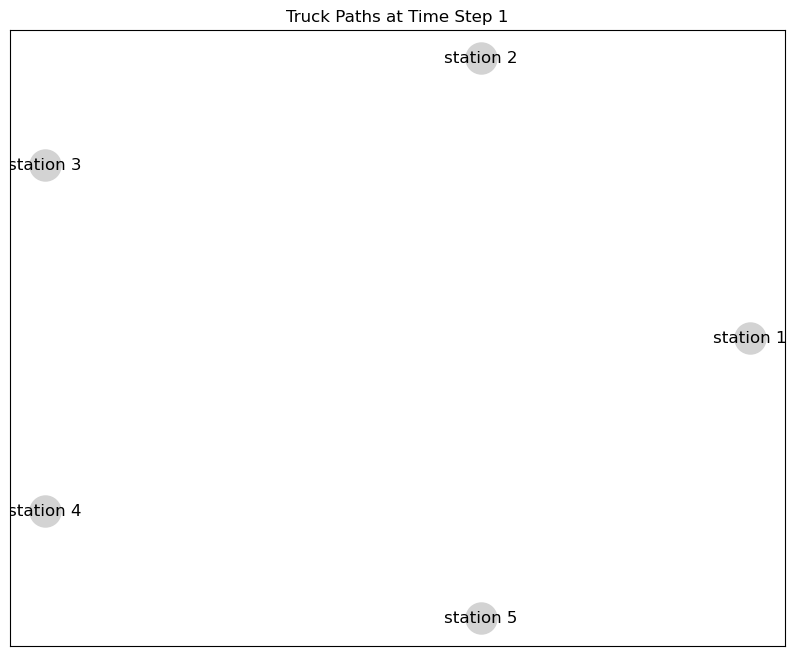

In [131]:
from IPython.display import HTML  # Import HTML from IPython.display
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation

# Function to update the animation at each frame
def update(frame):
    plt.clf()  # Clear previous plot
    G = nx.DiGraph()

    num_stations = len(stations)
    angle_step = 2 * np.pi / num_stations
    radius = 0.3  # Radius for station placement

    pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

    # Add nodes
    for station in stations:
        G.add_node(station)

    colors = ['blue', 'red']
    
    # Plot edges for each truck's path up to the current frame
    # for k, path in truck_paths.items():
    #     current_path = [p for p in path if p[0] <= frame]
    #     if len(current_path) > 1:
    #         edges = [(current_path[i][1], current_path[i + 1][1]) for i in range(len(current_path) - 1)]
    #         nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
    #                                edge_color=colors[k-1], style='dashed', label=f'Truck {k}')

    for k, path in truck_paths.items():
        current_path = [p for p in path if p[0] == frame]
        if len(current_path) > 1:
            edges = [(current_path[i][1], current_path[i + 1][1]) for i in range(len(current_path) - 1)]
            nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
                                       edge_color=colors[k-1], style='dashed', label=f'Truck {k}')
    
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title(f"Truck Paths at Time Step {frame + 1}")

# Create the animation
fig = plt.figure(figsize=(10, 8))
ani = animation.FuncAnimation(fig, update, frames=T, interval=500, repeat=False)

# Display the animation in the notebook using HTML display
HTML(ani.to_jshtml())

# Only Current Time Steps

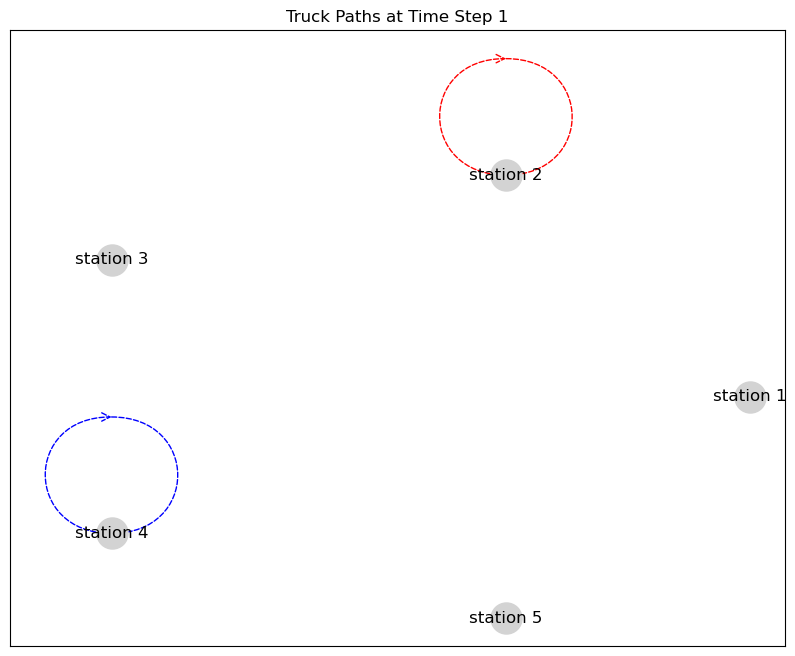

In [146]:
from IPython.display import HTML  # Import HTML from IPython.display
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation

num_stations = len(stations)
angle_step = 2 * np.pi / num_stations
radius = 0.3  # Radius for station placement
pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

# Function to update the animation at each frame
def update(frame):
    plt.clf()  # Clear previous plot
    G = nx.DiGraph()

    # Add nodes
    for station in stations:
        G.add_node(station)

    colors = ['blue', 'red']
    
    # Plot edges for each truck's path at the current frame
    for k, path in truck_paths.items():
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][0] == frame]
        if edges:
            nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
                                   edge_color=colors[k-1], style='dashed', label=f'Truck {k}')

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=12)
    plt.title(f"Truck Paths at Time Step {frame}")

# Create the animation
fig = plt.figure(figsize=(10, 8))
ani = animation.FuncAnimation(fig, update, frames=range(1, T + 1), interval=500, repeat=False)

# Display the animation in the notebook using HTML display
HTML(ani.to_jshtml())


# Without Graphing Stationary Trips

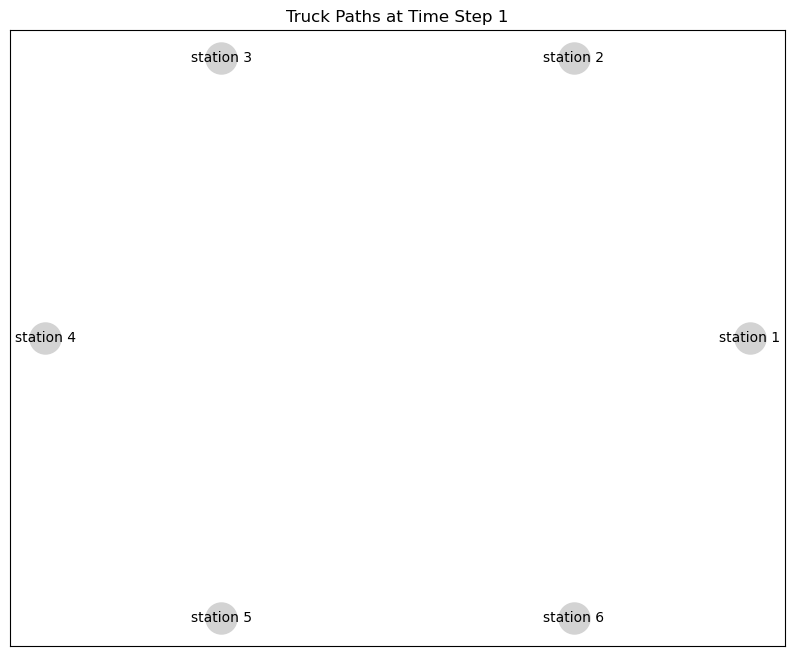

In [91]:
from IPython.display import HTML  # Import HTML from IPython.display
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import matplotlib.animation as animation


# Calculate positions of the stations once
num_stations = len(stations)
angle_step = 2 * np.pi / num_stations
radius = 0.3  # Radius for station placement
pos = {stations[i]: (np.cos(i * angle_step) * radius, np.sin(i * angle_step) * radius) for i in range(num_stations)}

# Function to update the animation at each frame
def update(frame):
    plt.clf()  # Clear previous plot
    G = nx.DiGraph()

    # Add nodes
    for station in stations:
        G.add_node(station)

    colors = ['blue', 'red', 'green', 'purple']
    
    # Plot edges for each truck's path at the current frame
    for k, path in truck_paths.items():
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][0] == frame and path[i][1] != path[i + 1][1]]
        if edges:
            nx.draw_networkx_edges(G, pos, edgelist=edges, arrowstyle='->', arrowsize=15,
                                   edge_color=colors[k-1], style='dashed', label=f'Truck {k}')

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, pos, font_size=10)
    plt.title(f"Truck Paths at Time Step {frame}")

# Create the animation
fig = plt.figure(figsize=(10, 8))
ani = animation.FuncAnimation(fig, update, frames=range(1, T + 1), interval=500, repeat=False)

# Display the animation in the notebook using HTML display
HTML(ani.to_jshtml())

# ani.save('truck_paths_animation.html', writer='html')

# Failed attempt at distance

In [64]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

stations = ['station 1', 'station 2', 'station 3', 'station 4', 'station 5']
start_levels = {'station 1': 12, 'station 2': 18, 'station 3': 12, 'station 4': 18, 'station 5': 15}
optimal_levels = {'station 1': 15, 'station 2': 15, 'station 3': 15, 'station 4': 15, 'station 5': 15}
over_stations, under_stations = [], []

# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
        
T = 20 # Number of time steps
K = 1 # Number of trucks
L = 3 # Number of bikes that can be moved in one time step

# Distance matrix (time steps between stations)
distances = {
    ('station 1', 'station 1'): 1, ('station 1', 'station 2'): 1, ('station 1', 'station 3'): 1, ('station 1', 'station 4'): 3, ('station 1', 'station 5'): 1,
    ('station 2', 'station 1'): 1, ('station 2', 'station 2'): 1, ('station 2', 'station 3'): 1, ('station 2', 'station 4'): 3, ('station 2', 'station 5'): 1,
    ('station 3', 'station 1'): 1, ('station 3', 'station 2'): 1, ('station 3', 'station 3'): 1, ('station 3', 'station 4'): 3, ('station 3', 'station 5'): 1,
    ('station 4', 'station 1'): 3, ('station 4', 'station 2'): 3, ('station 4', 'station 3'): 3, ('station 4', 'station 4'): 1, ('station 4', 'station 5'): 3,
    ('station 5', 'station 1'): 1, ('station 5', 'station 2'): 1, ('station 5', 'station 3'): 1, ('station 5', 'station 4'): 3, ('station 5', 'station 5'): 1
    }

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b = {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER)

# Previous station decision variable
p = {}
for t in range(2, T+1):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                p[s1, s2, t, k] = model.addVar(name="p_%s,%s,%s,%s" % (s1, s2, t, k), vtype=GRB.BINARY)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints

# Each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) == 1)

# Initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])

# Total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s, t, k] for s in stations) + b[t, k] == sum(y[s, 1, k] for s in stations) + b[1, k])

# Can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * gp.quicksum(p[s1, s, t, k] for s1 in stations))
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * gp.quicksum(p[s1, s, t, k] for s1 in stations))

# Constraint 8 in paper
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L + (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L - (y[s,t,k] - y[s,t-1,k]))
        for s in under_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L - (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L + (y[s,t,k] - y[s,t-1,k]))


# Ensure each truck is at one station per time step
for t in range(2, T+1):
    for k in range(1, K+1):
        for s1 in stations:
            model.addConstr(gp.quicksum(p[s1, s2, t, k] for s2 in stations) == x[s1, t-1, k])
            model.addConstr(gp.quicksum(p[s2, s1, t, k] for s2 in stations) == x[s1, t, k])

# Ensure trucks respect travel times
for t in range(2, T+1):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if distances[s1, s2] > (t - (t-1)):
                    model.addConstr(p[s1, s2, t, k] == 0)

# Ensure each truck travels within allowed time steps between stations
for t in range(2, T+1):
    for k in range(1, K+1):
        for s1 in stations:
            for s2 in stations:
                if distances[s1, s2] <= 1:
                    model.addConstr(p[s1, s2, t, k] <= x[s1, t-1, k] * x[s2, t, k])
                else:
                    model.addConstr(p[s1, s2, t, k] == 0)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

model.optimize()


Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

# Trying to do stuff w/ the model

In [28]:
# copying a bunch of stuff from cluster_model

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request
import simplejson
from cluster_model import ClusterModel
from datetime import timedelta
import pickle
import seaborn as sns

In [38]:
with open('/Users/Timothy/Documents/CSUREMM-main/data/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
stations = [station for station in cluster_model.station_data.keys()]

In [39]:
start_levels, optimal_levels = {}, {}
for station in stations:
    start_levels[station] = 0
    optimal_levels[station] = 0

start_levels['5th Ave & E 63 St'] = 3
optimal_levels['5th Ave & E 72 St'] = 3

neighbors = {}
for s in stations:
    limit = 0.05
    neighbors[s] = [s1 for s1 in stations if np.linalg.norm(np.array(positions[s] - np.array(positions[s1]))) < L]

T = 20
K = 1
L = 3

In [40]:
over_stations, under_stations, balanced_stations = [], [], []
# Fill over and under stations
for station in stations:
    if start_levels[station] > optimal_levels[station]:
        over_stations.append(station)
    elif start_levels[station] < optimal_levels[station]:
        under_stations.append(station)
    else:
        balanced_stations.append(station)
        
# T = 20 # Number of time steps
# K = 2 # Number of trucks
# L = 3 # Number of bikes that can be moved in one time step

model = gp.Model("bike_rebalancing")

# Decision variables
x, y, b = {}, {}, {}
for t in range(1, T+1):
    for k in range(1, K+1):
        for s in stations:
            x[s, t, k] = model.addVar(name="x_%s,%s,%s" % (s, t, k), vtype=GRB.BINARY)
            y[s, t, k] = model.addVar(name="y_%s,%s,%s" % (s, t, k), vtype=GRB.INTEGER)
        b[t, k] = model.addVar(name="b_%s,%s" % (t, k), vtype=GRB.INTEGER)

# Auxiliary variables for absolute deviation
deviation = {}
for s in stations:
    deviation[s] = model.addVar(name="deviation_%s" % s, vtype=GRB.INTEGER)

model.update()

# Objective function: minimize total absolute deviation from optimal levels
objective = gp.quicksum(deviation[s] for s in stations)
model.setObjective(objective, sense=GRB.MINIMIZE)

# Constraints:

# Constraint 1: can only move to an adjacent station
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(x[s,t,k] <= x[s,t-1,k] + gp.quicksum(x[s1,t-1,k] for s1 in neighbors[s]))


# Constraint 2: each truck must be at exactly 1 station always
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(x[s, t, k] for s in stations) == 1)

# Constraint 3: initialize bike levels at time 1
for s in stations:
    model.addConstr(sum(y[s, 1, k] for k in range(1, K+1)) == start_levels[s])

# Constraint 4 & 5: rebalancing can only bring a station closer to optimal level
for t in range(1, T+1):
    for s in over_stations:
        model.addConstr(optimal_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= start_levels[s])
    for s in under_stations:
        model.addConstr(start_levels[s] <= sum(y[s, t, k] for k in range(1, K+1)))
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) <= optimal_levels[s])
    for s in balanced_stations:
        model.addConstr(sum(y[s, t, k] for k in range(1, K+1)) == start_levels[s])

# Constraint 6: total number of bikes is constant
for t in range(1, T+1):
    for k in range(1, K+1):
        model.addConstr(sum(y[s, t, k] for s in stations) + b[t, k] == sum(y[s, 1, k] for s in stations) + b[1, k])

# Constraint 7: can move only when truck is at station; number of bikes moved is bounded
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in stations:
            model.addConstr(y[s, t, k] - y[s, t-1, k] <= L * x[s, t, k])
            model.addConstr(y[s, t-1, k] - y[s, t, k] <= L * x[s, t, k])

# Constraint 8: can either travel or load/unload, not both
for t in range(2, T+1):
    for k in range(1, K+1):
        for s in over_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L + (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L - (y[s,t,k] - y[s,t-1,k]))
        for s in under_stations:
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) <= L - (y[s,t,k] - y[s,t-1,k]))
            model.addConstr(L * (x[s,t,k] - x[s,t-1,k]) >= -L + (y[s,t,k] - y[s,t-1,k]))

# TEST: each truck can only house L bikes
for k in range(1, K+1):
    for t in range(1,T+1):
        model.addConstr(b[t,k] <= L)

# Absolute deviation constraints
for s in stations:
    model.addConstr(deviation[s] >= optimal_levels[s] - sum(y[s, T, k] for k in range(1, K+1)))
    model.addConstr(deviation[s] >= sum(y[s, T, k] for k in range(1, K+1)) - optimal_levels[s])

# At beginning and end, there must be no bikes in trucks
model.addConstr(gp.quicksum(b[T, k] for k in range(1, K+1)) == 0)
model.addConstr(gp.quicksum(b[1, k] for k in range(1, K+1)) == 0)

model.optimize()

Gurobi Optimizer version 11.0.2 build v11.0.2rc0 (mac64[x86] - Darwin 17.7.0 17G14042)

CPU model: Intel(R) Core(TM) i5-4250U CPU @ 1.30GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads



GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

In [37]:
for v in model.getVars():
    print(f"{v.varName}: {v.x}")

x_station 1,1,1: 0.0
y_station 1,1,1: 0.0
x_station 2,1,1: 0.0
y_station 2,1,1: 0.0
x_station 3,1,1: 0.0
y_station 3,1,1: 0.0
x_station 4,1,1: 0.0
y_station 4,1,1: 0.0
x_station 5,1,1: 0.0
y_station 5,1,1: 0.0
x_station 6,1,1: 0.0
y_station 6,1,1: 0.0
x_station 7,1,1: 1.0
y_station 7,1,1: 0.0
x_station 8,1,1: 0.0
y_station 8,1,1: 0.0
b_1,1: 0.0
x_station 1,2,1: 1.0
y_station 1,2,1: 0.0
x_station 2,2,1: 0.0
y_station 2,2,1: 0.0
x_station 3,2,1: 0.0
y_station 3,2,1: 0.0
x_station 4,2,1: 0.0
y_station 4,2,1: 0.0
x_station 5,2,1: 0.0
y_station 5,2,1: 0.0
x_station 6,2,1: 0.0
y_station 6,2,1: 0.0
x_station 7,2,1: 0.0
y_station 7,2,1: 0.0
x_station 8,2,1: 0.0
y_station 8,2,1: 0.0
b_2,1: 0.0
x_station 1,3,1: 0.0
y_station 1,3,1: 0.0
x_station 2,3,1: 0.0
y_station 2,3,1: 0.0
x_station 3,3,1: 0.0
y_station 3,3,1: 0.0
x_station 4,3,1: 0.0
y_station 4,3,1: 0.0
x_station 5,3,1: 1.0
y_station 5,3,1: 0.0
x_station 6,3,1: 0.0
y_station 6,3,1: 0.0
x_station 7,3,1: 0.0
y_station 7,3,1: 0.0
x_station 8,

In [34]:
lons = []
lats = []

for station in stations:
    lons.append(station_data[station]['lon'])
    lats.append(station_data[station]['lat'])

min_lat = min(lats)
max_lat = max(lats)
min_lon = min(lons)
max_lon = max(lons)

def shift(x,y):
    x1 = -1 + ((x - min(lons)) * 2 / (max(lons)-min(lons)))
    y1 = -1 + ((y - min(lats)) * 2 / (max(lats)-min(lats)))  
    return(x1, y1)

# stations = [station for station in cluster_model.station_data.keys()] ... defined earlier
positions = {}
for station in stations:
    lon = station_data[station]['lon']
    lat = station_data[station]['lat']
    x,y = shift(lon, lat)
    positions[station] = (x,y)

In [35]:
import matplotlib.pyplot as plt
import networkx as nx

truck_paths = {}

# if model.status == GRB.OPTIMAL:
if True:
    for k in range(1, K+1):
        path = []
        for t in range(1, T+1):
            for s in stations:
                if x[s, t, k].x > 0.5:  # If the truck k is at station s at time t
                    path.append((t, s, '{} bikes'.format(int(b[t,k].x))))
                    break
        truck_paths[k] = path
        print(f"Truck {k} path: {path}")
else:
    print("No optimal solution found.")


# Visualize the truck paths
def plot_paths(truck_paths):
    G = nx.DiGraph()
    
    # num_stations = len(stations)
    # side_length = int(np.ceil(np.sqrt(num_stations)))  # Number of nodes along one side of the square
    
    # # Determine the step size to spread nodes evenly in the square
    # step = 2 / (side_length - 1)
    
    # # Generate positions for each node
    # pos = {stations[i]: ((i % side_length) * step - 1, (i // side_length) * step - 1) for i in range(num_stations)}
    
    # Add nodes
    for station in stations:
        G.add_node(station)
    
    # Add edges with arrows for each truck path
    for k, path in truck_paths.items():
        for i in range(len(path) - 1):
            t1, s1 = path[i][:2]
            t2, s2 = path[i + 1][:2]
            G.add_edge(s1, s2, truck=k, time_step=t1)
    
    edge_colors = ['blue', 'red', 'green', 'purple']  # Different colors for different trucks
    # edge_styles = ['solid', 'dashed']  # Different styles for different trucks
    
    plt.figure(figsize=(10, 8))
    for k, path in truck_paths.items():
        # edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1)]
        # The above includes time steps where the trucks don't move. Below I have removed such trips
        edges = [(path[i][1], path[i + 1][1]) for i in range(len(path) - 1) if path[i][1] != path[i + 1][1]]
        nx.draw_networkx_edges(G, positions, edgelist=edges, arrowstyle='->', arrowsize=15, 
                               edge_color=edge_colors[k - 1], style='dashed', label=f'Truck {k}')
    
    nx.draw_networkx_nodes(G, positions, node_size=500, node_color='lightgray')
    nx.draw_networkx_labels(G, positions, font_size=10)

    from matplotlib.lines import Line2D
    legend_handles = [Line2D([0], [0], color=edge_colors[k - 1], lw=2, label=f'Truck {k}') for k in range(1, K+1)]
    plt.legend(handles=legend_handles)
    
    plt.title("Truck Paths")
    plt.show()

# Plot the paths
plot_paths(truck_paths)

IndexError: invalid index to scalar variable.